# Artificial Neural Networks Learning


## Importing library

In [85]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

from scipy import optimize

import pandas as pd

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

import utils

## Loading the data set and encoding the label

In [86]:
#  training data stored in arrays X, y
df = pd.read_csv("out.csv")

ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['Disease']])
transformed_disease = transformed.toarray()
df = df.drop(["Disease"], axis = 1)
X = np.array(df, dtype="float")[:, 1:]
print(transformed_disease.shape)
y = transformed_disease

(5409, 42)


In [87]:
print(X.shape)
print(y.shape)

(5409, 142)
(5409, 42)


## Model representation

Our neural network is shown in the following figure.

![](neural_network.png)

It has 3 layers - an input layer, a hidden layer and an output layer.
The training data was loaded into the variables `X` and `y` above.

In [54]:
# Setup the parameters you will use for this exercise
input_layer_size  = 142  # 142 symptoms
hidden_layer_size = 10  # 25 hidden units
num_labels = 42          # 42 diseases

### Activation fucntion:
$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$



In [55]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [56]:
print(sigmoid(0))

0.5


### Sigmoid Gradient


$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

In [57]:
def sigmoidGradient(z):
    g = sigmoid(z) * (1 - utils.sigmoid(z))
    return g

In [58]:
sigmoidGradient(0)

0.25

## Random Initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

<div class="alert alert-box alert-warning">
One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$.
</div>

Your job is to complete the function `randInitializeWeights` to initialize the weights for $\Theta$. Modify the function by filling in the following code:

```python
# Randomly initialize the weights to small values
W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
```
Note that we give the function an argument for $\epsilon$ with default value `epsilon_init = 0.12`.

In [71]:
def randInitializeWeights(L_in, L_out):
    """
    Parameters
    ----------
    L_in : int
        Number of incomming connections.
    
    L_out : int
        Number of outgoing connections. 
    
    epsilon_init : float, optional
        Range of values which the weight can take from a uniform 
        distribution.
    
    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms.
    ------------
    Initialize W randomly so that we break the symmetry while training
    the neural network. Note that the first column of W corresponds 
    to the parameters for the bias unit.
    """
    
    epsilon_init = np.sqrt(6) / np.sqrt(L_in + L_out)

    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    # ============================================================
    
    return W

In [72]:
Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()], axis=0)

## Data summarization

In [73]:
print('The size of Theta1 =', Theta1.shape)
print('The size of Theta2 =', Theta2.shape)
print('The size of X =', X.shape)

The size of Theta1 = (10, 143)
The size of Theta2 = (42, 11)
The size of X = (5409, 142)


## Feedforward and cost function

### Feedforward process

In [74]:
def predict(Theta1, Theta2, X):
    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    out = np.zeros((m, num_labels))
    for i in range (m):
        out[i][p[i]] = 1
    return out   

In [75]:
predict(Theta1, Theta2, X)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Neural Network Cost Function

The cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 42 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were the String that describe the name of the diseases but for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1 by one hot encoder (a built-in encoder in sklearn lib)

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

In [76]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    # Setup some useful variables
    m = y.shape[0]
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    # ======================= Feed_forward ==================
    X = np.concatenate([np.ones((m,1)), X], axis = 1)
    z_2 = X.dot(Theta1.T)
    a_2 = utils.sigmoid(z_2)
    a_2 = np.concatenate([np.ones((m ,1)), a_2], axis = 1)
    h_X = (utils.sigmoid(a_2.dot(Theta2.T)))
    
    # ===================== Backpropagation unregularized ===================
    delta_3 = h_X - y
    delta_2 = np.delete(delta_3.dot(Theta2), 0, 1)  * sigmoidGradient(z_2)
    
    Theta2_grad = (delta_3.T.dot(a_2))/m
    Theta1_grad = (delta_2.T.dot(X))/m
    
    # ====================== Adding the regularization term ==================
    for i in range (Theta1.shape[0]):
        for j in range (1, Theta1.shape[1]):
            Theta1_grad[i,j] = Theta1_grad[i,j] + lambda_/m * Theta1[i,j] 
    
    for i in range (Theta2.shape[0]):
        for j in range (1, Theta2.shape[1]):
            Theta2_grad[i,j] = Theta2_grad[i,j] + lambda_/m * Theta2[i,j]
    # ========================================================================
    for i in range (m):
        J = J + (-y[i].dot(np.log(h_X[i].T)) - (1 - y[i]).dot(np.log(1- h_X[i].T)))
    J  = J/m
    # =========================== regularization J ===========================
    J = J + lambda_ * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:, 1:]**2)) / (2 * m)
    # ========================================================================
    # Unroll gradients
    # grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)])
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

In [77]:
lambda_ = 0
J, _ = nnCostFunction(initial_nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
print('Cost at initial parameters: %.6f ' % J)

Cost at initial parameters: 30.005379 


The cost function for neural networks with regularization is given by:


$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

In [78]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(initial_nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at initial parameters with regularization: %.6f' % J)

Cost at initial parameters with regularization: 30.008653


## Backpropagation

![](backpropagation.png)

Given a training example $(x^{(t)}, y^{(t)})$, we will first run a “forward pass” to compute all the activations throughout the network, including the output value of the hypothesis $h_\theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output.

For an output node, we can directly measure the difference between the network’s activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer).

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a `+1` term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit. In `numpy`, if a 1 is a column matrix, adding one corresponds to `a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1)`.

1. For each output unit $k$ in layer 3 (the output layer), set 
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$. You may find logical arrays helpful for this task (explained in the previous programming exercise).

1. For the hidden layer $l = 2$, set 
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$

1. Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$. In `numpy`, removing $\delta_0^{(2)}$ corresponds to `delta_2 = delta_2[1:]`.
$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)} (a^{(l)})^{(T)} $$

1. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

## Learning parameters using `scipy.optimize.minimize`

After you have successfully implemented the neural network cost function
and gradient computation, the next step we will use `scipy`'s minimization to learn a good set parameters.

In [79]:
options= {'maxiter': 200}

#  You should also try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

In [80]:
pred = utils.predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 97.257657


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [82]:
options= {'maxiter': 200}
lambda_ = 1
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X_train, y_train, lambda_)

res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

nn_params = res.x

Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

In [83]:
pred = utils.predict(Theta1, Theta2, X_test)
print('Test Set Accuracy: %f' % (np.mean(pred == y_test) * 100))

Test Set Accuracy: 97.214154


## Tunning the parameters

In [89]:
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.2)

In [90]:
X_train, X_cross_val, y_train, y_cross_val = train_test_split(X_train_cv, y_train_cv, test_size=0.25)

In [91]:
print(X_train.shape)
print(X_cross_val.shape)
print(X_test.shape)

(3245, 142)
(1082, 142)
(1082, 142)


In [92]:
input_layer_size  = 142  # 142 symptoms
hidden_layer_size_list = np.linspace(1, 50, 50, dtype = int)  # 25 hidden units
num_labels = 42          # 42 diseases

### increase the number of neurons in hidden layer

In [28]:
accuracy_list = []
for hidden_layer_size in hidden_layer_size_list:
    options= {'maxiter': 200}
    lambda_ = 1
    
    Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
    initial_nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()], axis=0)
    costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                            hidden_layer_size,
                                            num_labels, X_train, y_train, lambda_)

    res = optimize.minimize(costFunction,
                            initial_nn_params,
                            jac=True,
                            method='TNC',
                            options=options)

    nn_params = res.x

    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    pred = utils.predict(Theta1, Theta2, X_cross_val)
    accuracy = np.mean(pred == y_cross_val) * 100
    accuracy_list.append(accuracy)

<ipython-input-16-5b8138aca21a>:57: RuntimeWarning: divide by zero encountered in log
  J = J + (-y[i].dot(np.log(h_X[i].T)) - (1 - y[i]).dot(np.log(1- h_X[i].T)))
<ipython-input-5-478bf6890dec>:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


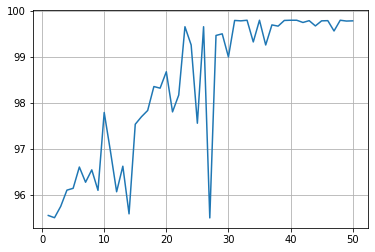

In [93]:
import matplotlib.pyplot as plt
plt.plot(hidden_layer_size_list, accuracy_list)
plt.grid()
plt.show()

In [98]:
options= {'maxiter': 200}
lambda_ = 1
hidden_layer_size = 29

Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()], axis=0)
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X_train_cv, y_train_cv, lambda_)

res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

nn_params = res.x

Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))
pred = utils.predict(Theta1, Theta2, X_test)
accuracy = np.mean(pred == y_test) * 100

/Users/anhoang/Desktop/devzone/Disease-prediction/utils.py:88: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
<ipython-input-55-478bf6890dec>:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


In [99]:
print(accuracy)

99.77114690608221


In [100]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       0.96      0.96      0.96        27
           2       1.00      0.92      0.96        26
           3       0.91      1.00      0.95        29
           4       1.00      0.81      0.90        27
           5       1.00      0.95      0.98        22
           6       0.95      1.00      0.98        20
           7       0.96      1.00      0.98        24
           8       0.86      0.86      0.86        22
           9       0.96      1.00      0.98        26
          10       0.96      1.00      0.98        23
          11       1.00      1.00      1.00        57
          12       0.93      0.93      0.93        29
          13       1.00      0.88      0.94        26
          14       1.00      0.96      0.98        27
          15       0.96      0.96      0.96        25
          16       0.86      1.00      0.93        19
          17       0.88    

## Reduce computational workload with separate dataset

In [33]:
def pca(X):
    # Useful values
    m, n = X.shape

    U = np.zeros(n)
    S = np.zeros(n)

    cov_matrix = X.T.dot(X) / m
    U, S, V = np.linalg.svd(cov_matrix)
    
    return U, S

def projectData(X, U, K):

    Z = np.zeros((X.shape[0], K))

    U_k = (U.T[:K]).T
    Z = X.dot(U_k)

    return Z

In [34]:
U, S = pca(X)

In [115]:
S

array([1.31347126e+03, 1.49795361e+01, 1.11644569e+01, 7.54970468e+00,
       7.00292088e+00, 5.24255361e+00, 4.89772338e+00, 4.72756993e+00,
       4.36203842e+00, 3.72124941e+00, 3.51548735e+00, 3.33982194e+00,
       3.06977631e+00, 2.98763155e+00, 2.87916406e+00, 2.71336647e+00,
       2.38601536e+00, 2.25797015e+00, 2.18454512e+00, 1.98575223e+00,
       1.87022105e+00, 1.79841158e+00, 1.74143210e+00, 1.62632938e+00,
       1.52043486e+00, 1.35324238e+00, 1.31327983e+00, 1.25182809e+00,
       1.18882824e+00, 1.11734556e+00, 9.94964184e-01, 9.89098670e-01,
       8.90939733e-01, 8.05149096e-01, 7.30690971e-01, 6.82044223e-01,
       6.32389734e-01, 5.87101786e-01, 5.59411457e-01, 4.93630408e-01,
       4.74658729e-01, 4.17437378e-01, 3.50528392e-01, 3.36572137e-01,
       3.15068096e-01, 3.07543628e-01, 2.19946196e-01, 1.79591042e-01,
       1.72291761e-01, 1.46708901e-01, 1.38315853e-01, 1.23951437e-01,
       1.18328254e-01, 1.15058532e-01, 9.83775123e-02, 8.71085743e-02,
      

In [35]:
Z_1 = projectData(X, U, 3)

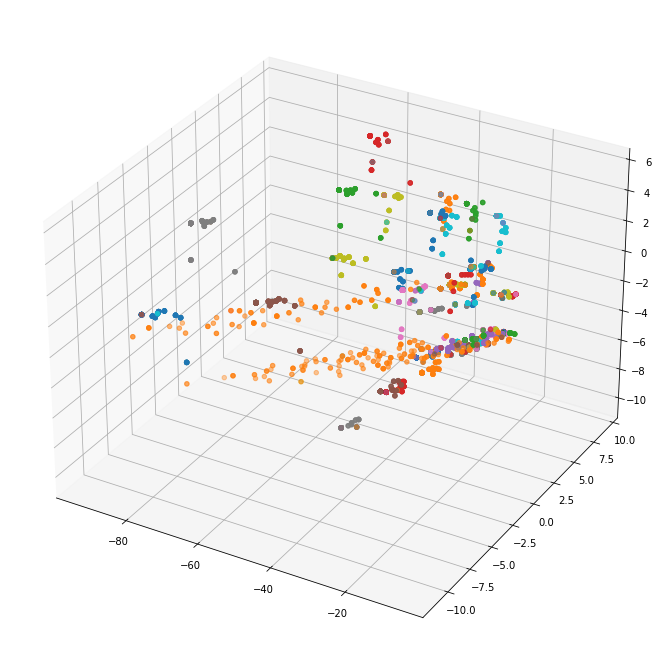

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 12))
ax = fig.add_subplot(projection='3d')
for i in range(len(y)):
    ax.scatter( Z_1[np.where(np.argmax(y, axis = 1) == i), 0],
               Z_1[np.where(np.argmax(y, axis = 1) == i),1],
               Z_1[np.where(np.argmax(y, axis = 1) == i),2])

In [37]:
prefferedDim = np.linspace(3,60,58, dtype = int)
options= {'maxiter': 150}
lambda_ = 1
f1_score_list = []
for i in prefferedDim:
    X_train_cv, X_test, y_train_cv, y_test = train_test_split(projectData(X, pca(X)[0], i), y, test_size=0.2)
    X_train, X_cross_val, y_train, y_cross_val = train_test_split(X_train_cv, y_train_cv, test_size=0.25)
    input_layer_size = i
    Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

    initial_nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()], axis=0)

    costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                            hidden_layer_size,
                                            num_labels, X_train, y_train, lambda_)

    res = optimize.minimize(costFunction,
                            initial_nn_params,
                            jac=True,
                            method='TNC',
                            options=options)

    nn_params = res.x

    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    pred = utils.predict(Theta1, Theta2, X_cross_val)
    f1_score_list.append(f1_score(y_cross_val, pred,  average='micro'))

/Users/anhoang/Desktop/devzone/Disease-prediction/utils.py:88: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
<ipython-input-5-478bf6890dec>:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
<ipython-input-16-5b8138aca21a>:57: RuntimeWarning: divide by zero encountered in log
  J = J + (-y[i].dot(np.log(h_X[i].T)) - (1 - y[i]).dot(np.log(1- h_X[i].T)))
<ipython-input-16-5b8138aca21a>:57: RuntimeWarning: divide by zero encountered in log
  J = J + (-y[i].dot(np.log(h_X[i].T)) - (1 - y[i]).dot(np.log(1- h_X[i].T)))
/Users/anhoang/Desktop/devzone/Disease-prediction/utils.py:88: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
<ipython-input-5-478bf6890dec>:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
<ipython-input-16-5b8138aca21a>:57: RuntimeWarning: divide by zero encountered in log
  J = J + (-y[i].dot(np.log(h_X[i].T)) - (1 - y[i]).dot(np.log(1- h_X[i].T)))
/U

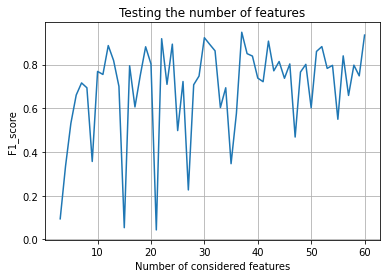

In [38]:
import matplotlib.pyplot as plt
plt.plot(prefferedDim, f1_score_list)
plt.xlabel("Number of considered features")
plt.ylabel("F1_score")
plt.title("Testing the number of features")
plt.grid()
plt.show()

In [113]:
input_layer_size = 12

X_train_cv, X_test, y_train_cv, y_test = train_test_split(projectData(X, pca(X)[0], input_layer_size), y, test_size=0.2)
X_train, X_cross_val, y_train, y_cross_val = train_test_split(X_train_cv, y_train_cv, test_size=0.25)

Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

initial_nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()], axis=0)

costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X_train_cv, y_train_cv, lambda_)

res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

nn_params = res.x

Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))
pred = utils.predict(Theta1, Theta2, X_test)
accuracy = np.mean(pred == y_test) * 100
print(accuracy)

99.6171111697914


In [114]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.95      0.95      0.95        22
           2       0.74      1.00      0.85        29
           3       0.91      0.95      0.93        21
           4       0.82      0.88      0.85        32
           5       0.77      0.96      0.86        28
           6       1.00      0.94      0.97        18
           7       0.86      1.00      0.92        18
           8       0.89      0.93      0.91        27
           9       0.65      0.95      0.77        21
          10       0.97      1.00      0.98        28
          11       0.95      0.93      0.94        44
          12       1.00      1.00      1.00        21
          13       1.00      0.88      0.94        34
          14       0.96      1.00      0.98        27
          15       0.96      0.93      0.94        27
          16       0.82      0.74      0.78        19
          17       0.97    